# Reaction Cross Section Challenge


Notebook adapted from the ROSE challenges made by Daniel Odell and Pablo Giuliani: https://indico.cern.ch/event/1223721/contributions/5394829/. Functions for calculating the wave-function solutions and phaseshifts adapted from the ROSE github: https://github.com/odell/rose

The purpose of this challenge is to extract information of a nucleus through the scattering cross section of particles that interact with it (in this case, neutrons). We will use an optical potential to model such interaction.

The acompanying re-scaled Schrodinger equation is:

$$
\left[ -\frac{d^2}{ds^2} + \frac{\ell(\ell+1)}{s^2} + U(s,\omega,k) - 1 \right] \phi(s) = 0~,
$$

where

$$
s\equiv k r~,
$$

where $k$ is the center-of-mass momentum and $r$ is the relative separation, and

$$
U(s,\omega,k) \equiv \frac{2\mu}{\hbar^2 k^2}V(s/k,\omega)~.
$$.

We use the optical potential:


$$

    \omega= \{V_v,W_v,W_d,R,a\},

$$


$$

    \begin{aligned}
      &V(r,\omega) =-V_v f_\text{WS}(r,R,a) - iW_v f_\text{WS}(r,R,a) \\
      &-i4a_dW_d \frac{d}{dr}f_\text{WS}(r,R,a),
    \end{aligned}

$$
where the Woods-Saxon term is defined as:
\begin{equation}
    f_\text{WS}(r,R,a) = \Big[1+\text{exp}\Big( \frac{r-R}{a}\Big)  \Big]^{-1}.
\end{equation}

It contains three terms, a real volume interaction proportional to $V_v$, an imaginary volume interaction proportional to $W_v$, and an imaginary surface interaction proportional to $W_d$.

The Schrodinger equation must be solver for various values of $l$ up to some value $L_\text{max}$. Every solution is then compared to the asymptotic solutuions to Schrodinger equation in the abscence of a short range potential:
$$

    \phi(s)_{s\rightarrow \infty} \propto e^{i\delta_\ell}\Big(\text{cos}\delta_\ell\  F_\ell(0,s)+\text{sin}\delta_\ell \ G_\ell(0,s) \Big).

$$

that allows us to extract the phase shifts from the following equations:
$$

e^{2i\delta*{\ell}} =\frac{H^-*\ell(a)-aR*\ell H'^{-}\_\ell(a)}{H^{+}*\ell(a)-aR\_\ell H'^{+}\_\ell(a)},

$$

with:


$$

H^{\pm}(s)\equiv G*\ell(0,s)\pm iF*\ell(0,s)

$$

and the matching value at the matching radius defined as:


$$

R_{\ell}\equiv \frac{1}{a}\frac{\phi(a)}{\phi'(a)}.

$$

Once the phase shifts have been computed, we can obtain the amplitude:
$$

    f_n(\theta) = \frac{1}{2ik}\sum_{\ell=0}^{L_\text{max}}(2\ell+1)P_\ell(\text{cos}\theta)\big(e^{2i\delta_\ell}-1 \big),

$$
where $P_\ell(\text{cos}\theta)$ are the Legendre polynomials. The differential cross section is then defined:


$$

\frac{d\sigma}{d\Omega}(\theta) = 10|f_n(\theta)|^2.

$$

That factor of "10" is needed such that the final answer is in the correct units and scalling of [mb/sr]

Your tasks are to:

- Import and plot the cross section data for 40Ca + neutrons at the energy 14 MeV.
- Familizarize yourself on how to use the functions below to solve the scattering equation and obtain the phase shifts.
- Optimize the five model parameters to reproduce the data as close as possible. Be mindful on the order of the parameters used in the solver we give you below.
$$


In [1]:
# Importing all the good stuff

import numpy as np
import matplotlib.pyplot as plt

from scipy.special import spherical_jn
from scipy.special import spherical_yn
from scipy.special import eval_legendre
from scipy.integrate import solve_ivp


from scipy.misc import derivative
import warnings  # Done to continue using the "derivative" method, if things don't work in the future, check if this is the problem

# Filter out DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Definition of some math functions we will need


def F(rho, ell):
    """
    Bessel function of the first kind.
    """
    return rho * spherical_jn(ell, rho)


def G(rho, ell):
    """
    Bessel function of the second kind.
    """

    return -rho * spherical_yn(ell, rho)


def H_plus(rho, ell):
    """
    Hankel function of the first kind.
    """
    return G(rho, ell) + 1j * F(rho, ell)


def H_minus(rho, ell):
    """
    Hankel function of the second kind.
    """
    return G(rho, ell) - 1j * F(rho, ell)


def H_plus_prime(rho, ell, dx=1e-6):
    """
    Derivative of the Hankel function (first kind) with respect to rho.
    """
    return derivative(lambda z: H_plus(z, ell), rho, dx=dx)


def H_minus_prime(rho, ell, dx=1e-6):
    """
    Derivative of the Hankel function (second kind) with respect to rho.
    """
    return derivative(lambda z: H_minus(z, ell), rho, dx=dx)


def Gamow_factor(l):
    if l == 0:
        return 1
    else:
        return 1 / (2 * l + 1) * Gamow_factor(l - 1)

In [3]:
# Defiining the details of our system

A = 40

HBARC = 197.326

AMU = 931.494102  # MeV/c^2, Particle Data Group
MASS_N = 1.008665 * AMU  # MeV/c^2 PDG
MASS_P = 1.007276 * AMU  # MeV/c^2 PDG
B_40CA = 342.0522  # BMEX

MASS_40CA = 20 * MASS_P + 20 * MASS_N - B_40CA
MU = MASS_40CA * MASS_N / (MASS_40CA + MASS_N)

energy = 14  # center-of-mass scattering energy, fixed for this example
k = np.sqrt(2 * MU * energy) / HBARC


l_max = 10
l_list = np.array(range(l_max + 1))

In [4]:
# Interaction


def wood_saxon(r, R, a):
    return 1 / (1 + np.exp((r - R) / a))


def wood_saxon_prime(r, R, a):
    return -1 / a * np.exp((r - R) / a) / (1 + np.exp((r - R) / a)) ** 2


def optical_potential(r, params):
    Vv, Wv, Wd, R, a = params
    return (
        -Vv * wood_saxon(r, R, a)
        - 1j * Wv * wood_saxon(r, R, a)
        - 4j * a * Wd * wood_saxon_prime(r, R, a)
    )

In [5]:
# Defining the \tilde U for the re-scaled S. Equation
def interaction_tilde(s, energy, params):
    k = np.sqrt(2 * MU * energy) / HBARC
    return 1.0 / energy * optical_potential(s / k, params)

In [6]:
# Import data from text file
exp_data = [[], [], []]
line = 0
with open("40CaCSData.txt") as in_file:
    lines = in_file.readlines()
    for line in lines[1:]:
        vals = line.split()
        exp_data[0].append(float(vals[0]))
        exp_data[1].append(float(vals[1]))
        exp_data[2].append(float(vals[2]))

In [7]:
# Good guesses for the parameters:

Vv0 = 55
Wv0 = 10
Wd0 = 0

R0 = 4
a0 = 0.6

params0 = np.array([Vv0, Wv0, Wd0, R0, a0])

In [8]:
# Boundaries for the integration of the WF
s_0 = 1e-5
s_f = 20
matching_R = s_f
mesh_points = 400
s_mesh = np.linspace(s_0, s_f, mesh_points)

In [9]:
# Numerical solver to get the solutions to the S. Equation. This function returns the wave function and its derivative over the mesh we defined: [\phi(s), \phi ' (s)]


def solve_se(
    energy: float,  # E_{c.m.} (MeV)
    args: np.ndarray,  # interaction parameters
    s_endpts: np.ndarray = np.array([s_0, s_f]),  # s where phi(s) is calculated
    l: int = 0,  # angular momentum
    rho_0=None,  # initial rho value ("effective zero")
    phi_threshold: float = 1e-9,  # minimum phi value (zero below this value)
    **solve_ivp_kwargs
):
    """
    Solves the Schrödinger equation at the specified center-of-mass energy.
    Returns a 2-column matrix. The first is the r values. The second is the
    reduced radial wavefunction, u(r). (The optional third - based on
    return_uprime - is u'(r).)
    """

    C_l = Gamow_factor(l)
    if rho_0 is None:
        rho_0 = (phi_threshold / C_l) ** (1 / (l + 1))
    phi_0 = C_l * rho_0 ** (l + 1)
    phi_prime_0 = C_l * (l + 1) * rho_0**l

    initial_conditions = np.array([phi_0 + 0j, phi_prime_0 + 0j])

    sol = solve_ivp(
        lambda s, phi: np.array(
            [
                phi[1],
                (interaction_tilde(s, energy, args) + l * (l + 1) / s**2 - 1.0)
                * phi[0],
            ]
        ),
        s_endpts,
        initial_conditions,
        rtol=1e-11,
        atol=1e-11,
        dense_output=True,
        **solve_ivp_kwargs
    )

    solution = sol.sol(s_mesh)
    # Normalizing since we were having some issues with the initial conditions (The Schrodinger Eq upstairs is homogeneous)
    return solution / max(abs(solution[0]))

In [10]:
# Function for calculating the phase shift given a solution


def delta(
    wf_vals: np.ndarray,  # value of the wf and its derivative at the matching radius phi(s_0), phi'(s_0)
    l: int,  # angular momentum
    s_0: float,  # phaseshift is extracted at phi(s_0)
):
    """
    Calculates the lth partial wave phase shift at the specified energy.
    """

    rl = 1 / s_0 * (wf_vals[0] / wf_vals[1])
    return (
        np.log(
            (H_minus(s_0, l) - s_0 * rl * H_minus_prime(s_0, l))
            / (H_plus(s_0, l) - s_0 * rl * H_plus_prime(s_0, l))
        )
        / 2j
    )

## Lets try our things on a specific example


In [11]:
l0 = 2  # Hand picked value of the angular momemntum
solution0 = solve_se(energy=energy, args=params0, l=l0)

Text(0.5, 0, '$s$')

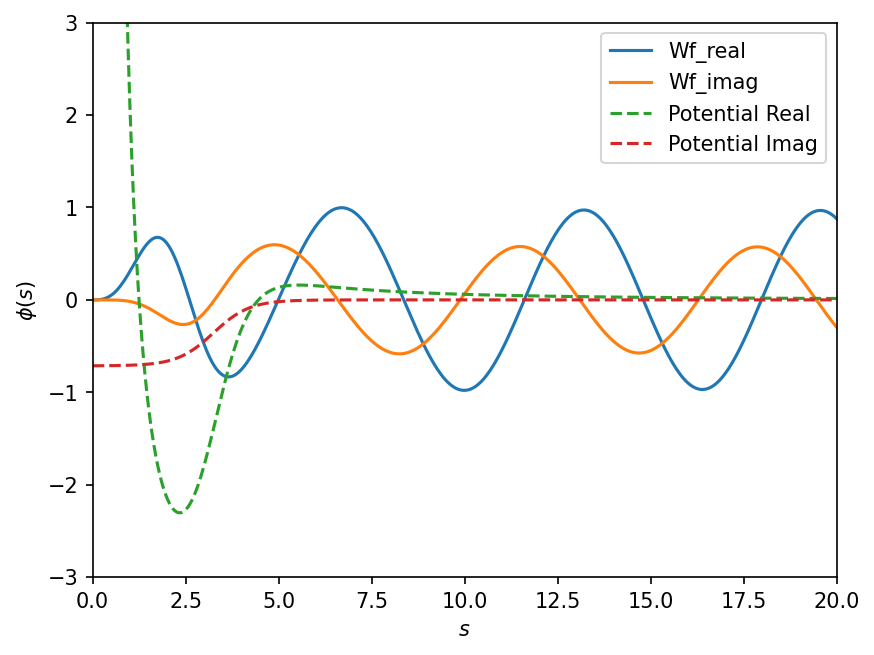

In [12]:
fig = plt.figure(dpi=150)

plt.plot(s_mesh, np.real(solution0[0]), label="Wf_real")
plt.plot(s_mesh, np.imag(solution0[0]), label="Wf_imag")

plt.plot(
    s_mesh,
    np.real(interaction_tilde(s_mesh, energy, params0)) + l0 * (l0 + 1) / s_mesh**2,
    label="Potential Real",
    linestyle="dashed",
)

plt.plot(
    s_mesh,
    np.imag(interaction_tilde(s_mesh, energy, params0)),
    label="Potential Imag",
    linestyle="dashed",
)

plt.ylim(-3, 3)
plt.xlim(0, 20)
plt.legend()
plt.ylabel(r"$\phi(s)$")
plt.xlabel(r"$s$")

In [13]:
# Calling the function that computes the phase shift

print(delta(solution0[-1], 2, matching_R))

(-1.3004423996026606+8.50708392619171e-14j)


In [14]:
# Rest of the code goes here, now you need to put all this together to calculate the differential cross section for neutrons on 40Ca at 14 MeV, good luck!
def scattering_amplitude(angle: float, delta_l: np.ndarray) -> complex:
    P_l = eval_legendre(l_list, np.full(l_max + 1, np.cos(angle * np.pi / 180)))
    return np.sum((2 * l_list + 1) * P_l * (np.exp(2j * delta_l) + 1)) / (2j * k)


def diff_cross_section(amp: complex) -> float:
    return 10.0 * np.real_if_close(amp * np.conj(amp))

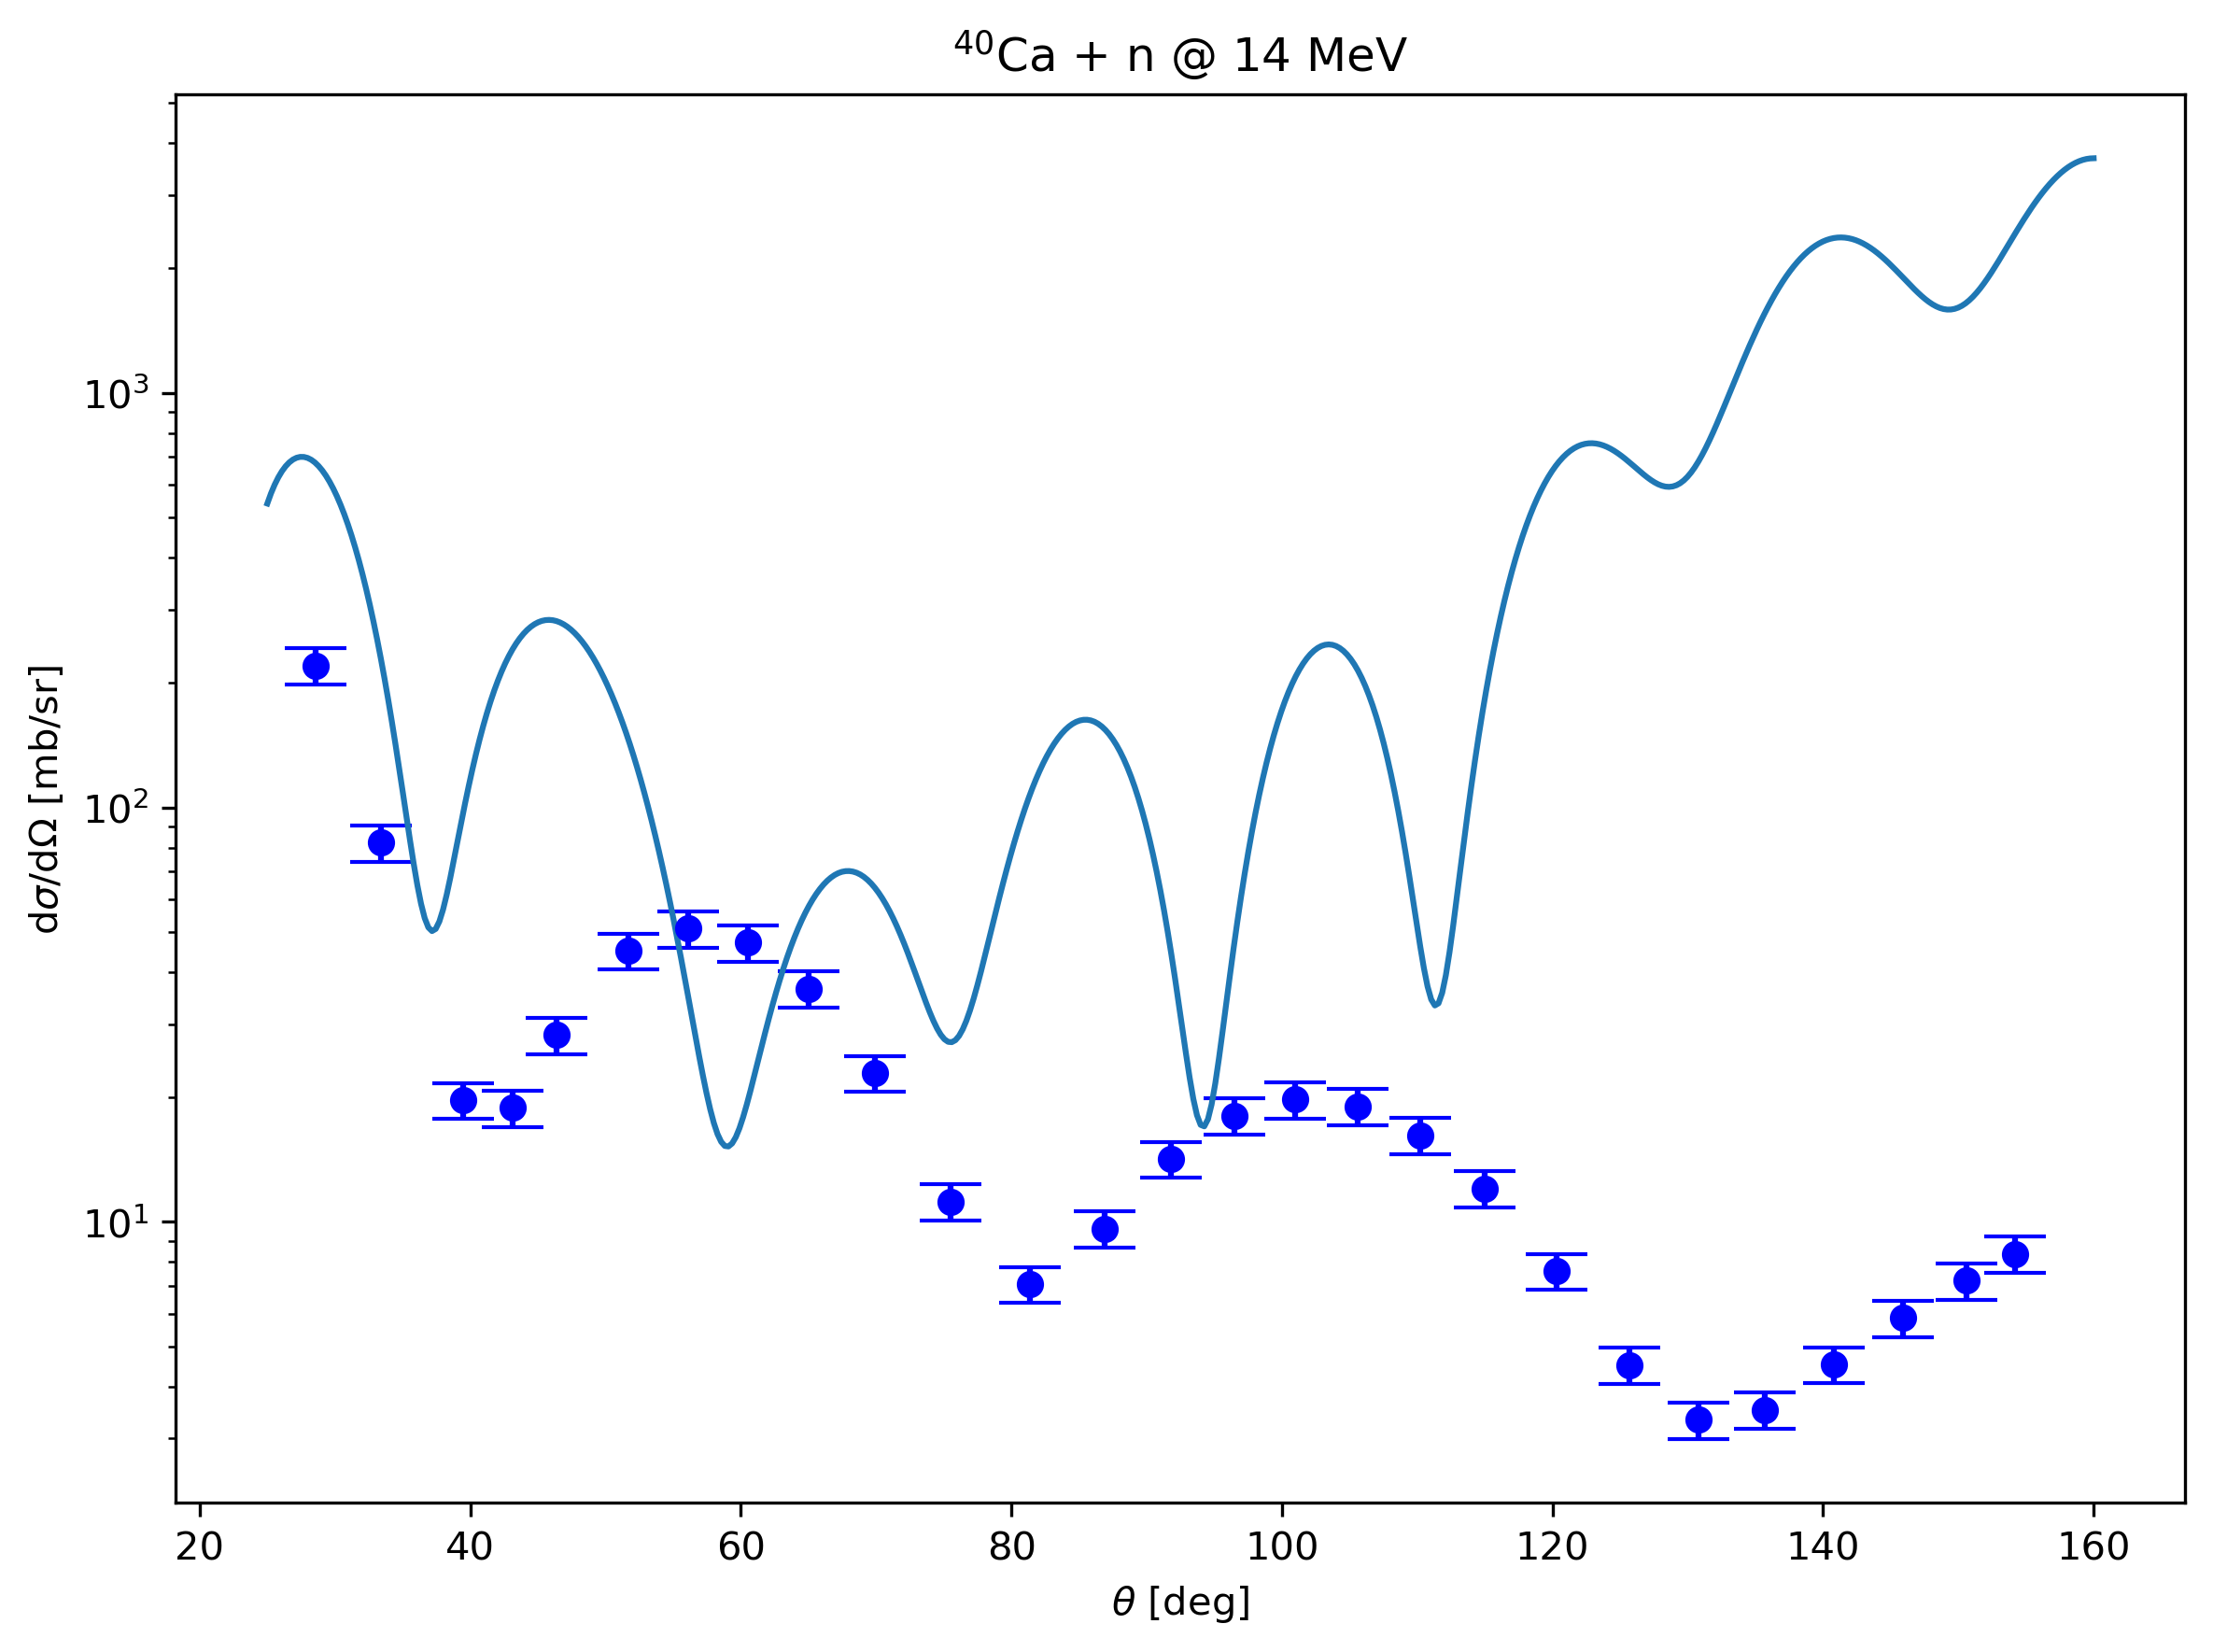

In [15]:
# Solve for deltas for all l values up to l = 10
delta_l_values = np.array(
    [
        delta(solve_se(energy=energy, args=params0, l=l)[-1], l, matching_R)
        for l in l_list
    ]
)
angles = np.linspace(25, 160, 500)
calc_cross_sections = np.array(
    [diff_cross_section(scattering_amplitude(ang, delta_l_values)) for ang in angles]
)

# Plot calculations with data for comparison
plt.figure(figsize=(8, 6), dpi=300)
plt.errorbar(
    exp_data[0],
    exp_data[1],
    exp_data[2],
    fmt="bo",
    solid_capstyle="projecting",
    capsize=8,
)
plt.plot(angles, calc_cross_sections)
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"d$\sigma$/d$\Omega$ [mb/sr]")
plt.yscale("log")
plt.title(r"$^{40}$Ca + n @ 14 MeV")
plt.tight_layout()